<a href="https://colab.research.google.com/github/ConnorSA/tutorials_ext/blob/master/DADApy_tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1: Intrinsic dimension

In this part we analyse the functioning of *intrinsic dimension estimators*, the tutorual is divided in two sections

1. in the first section we illustrate the algorithmic principles on simple synthetic datasets, paying attention to the importance of scale


2. in the second section we show how the algorithms can be used to investigate the inner representations of neural networks, reproducing the key result of:
    - *Intrinsic dimension of data representations in deep neural networks*, Ansuini et al., NeurIPS (2019) https://proceedings.neurips.cc/paper/2019/file/cfcce0621b49c983991ead4c3d4d3b6b-Paper.pdf

## Importing and installing the required packages

In [ ]:
# import standard python packages
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")


In [ ]:
# and then install "DADApy" a package for "Distance-based Analyis of DAta-manifolds"

#!pip install git+https://github.com/sissa-data-science/dadapy.git

!pip install dadapy

     |████████████████████████████████| 191 kB 5.0 MB/s 
  Created wheel for dadapy: filename=dadapy-0.1.0-cp37-cp37m-linux_x86_64.whl size=401006 sha256=381a0bcba15de57af842789a9be325e352c442492f0cce30d5bc57bdb239ccaf
  Stored in directory: /root/.cache/pip/wheels/17/3c/0b/4f0f68d808acf5fc11d7dcf17bb8e3487004065f0f65130253
Successfully built dadapy


In [ ]:
# import the main class "Data" from DADApy

from dadapy import Data


## Method illustration (synthetic data)

### Plot function 


In [ ]:
def plot_data(X):
    """Useful function to plot data in 3d"""
    fig = plt.figure(figsize = (11, 3))
    gs = GridSpec(1, 3)


    ax = fig.add_subplot(gs[0], projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s = 0.05)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(20, 85)

    #two dimensional xz cut of the swiss roll
    ax = fig.add_subplot(gs[1])
    ax.scatter(-X[:, 0],X[:, 2], s = 0.05)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title('Orthogonal projection on the XZ plane')

    ax = fig.add_subplot(gs[2], projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s = 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(-4.9, -4.6)
    ax.set_xlim(-0.2, 0.5)
    ax.view_init(0, 80)

    gs.tight_layout(fig)

    
%matplotlib inline

### Estimate of the intrinsic dimension of a noisless mainfold

N sample = 5000


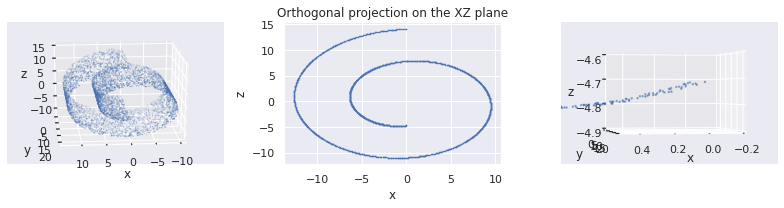

In [ ]:
# let's start by sampling a 2d noiseless dataset embedded in a higher dimensional space

from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples = 5000, noise = 0.0)
print(f'N sample = {X.shape[0]}')
plot_data(X)

Even though the manifold is embedded in 3 dimensions, it is two dimesional, note that even at very short scales the manifold is "flat".

What kind of *id* do we expect to get using 2NN? What if we change the scale of the computation by performing a decimation of the dataset?

In [ ]:
# initialise the Data class from DADApy with a matrix of coordinates

data = Data(X)

In [ ]:
# compute the intrinsic dimension using the 2NN algorithm
# the parameter 'decimation' is the proportion of data used 
# to compute the ID, for decimation=1. all data are used

ID, err, scale = data.compute_id_2NN(decimation=.1)

print(f'Intrinsic dimension = {ID: .2f}')
print(f'Intrinsic dimension scale = {scale: .2f}')

Intrinsic dimension =  1.92
Intrinsic dimension scale =  1.23


In [ ]:
# incidentally, the id information is also available via class attributes

print('ID estimate:',       data.intrinsic_dim)
print('ID estimate std: ',  data.intrinsic_dim_err)
print('ID estimate scale:', data.intrinsic_dim_scale)


ID estimate: 1.9223228942504977
ID estimate std:  0.03970707879642694
ID estimate scale: 1.234130316457966


### Intrinsic dimension of a noisy mainfold


N sample = 11294


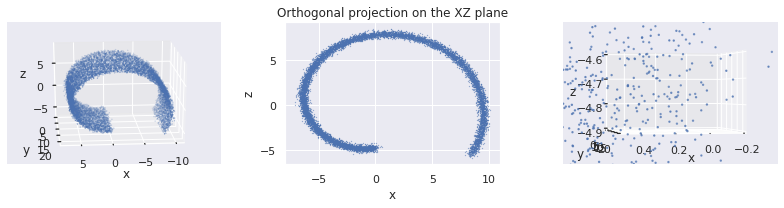

In [ ]:
# now let's sample a similar dataset, but with some noise, and perform the same operations perfomed previously

from sklearn.datasets import make_swiss_roll
noise = 0.2
X, t = make_swiss_roll(n_samples = 20000, noise = noise)
X = X[np.where(t<10)]
print(f'N sample = {X.shape[0]}')
plot_data(X)

The manifold is again two dimesional, but at very short scales the data seem to fill the space uniformly.

What kind of *id* do we expect to get using 2NN this time?

In [ ]:
data = Data(X)

In [ ]:
ID, err, scale = data.compute_id_2NN(decimation =.01)
print(f'Intrinsic dimension = {ID: .2f}')
print(f'Intrinsic dimension scale = {scale: .2f}')

Intrinsic dimension =  2.13
Intrinsic dimension scale =  1.80


###### Iterative computation of 2NN estimates on decimated datasets


It is typically a good ides to plot the estimated ID as a function of the scale at which that is computed. 

DADApy implements functions that do that automatically, let's see how they work.

In [ ]:
# "return_id_scaling" returns IDs estimated at different scales
# using a minimum of N_min points

IDs, errs, scales = data.return_id_scaling_2NN(N_min=10)

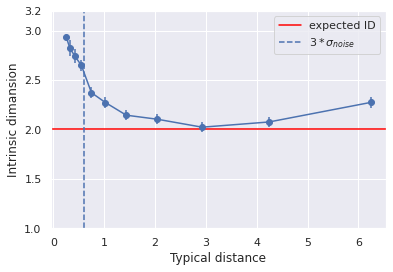

In [ ]:
#plot the intrinsic dimension as a function of the scale

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(scales, IDs, marker = 'o')
ax.errorbar(scales, IDs, 2*errs, marker = 'o')
ax.axhline(2, label = 'expected ID', color  = 'red')
ax.axvline(3*noise, label = '$3*\sigma_{noise}$', linestyle = '--')
ax.set_yticks([1, 1.5, 2, 2.5, 3, 3.2])
ax.set_ylabel('Intrinsic dimansion')
ax.set_xlabel('Typical distance')
ax.legend()

The ID is initially estimated around $3$ as that scales is dominated by noise, and then plateaus at around $2$.
Plateaus are the best signs of a meaningful ID.

###### Gride algorithm


The `return_scaling_2NN` perform a decimation of the dataset to access longer scales, this works very well, but long scales can be also probed directly using the "Gride" algorithm

In [ ]:
# return_id_scaling_gride returns IDs up to a maximum nearest
# neighbour range given by range_max

IDs, errs, scales = data.return_id_scaling_gride(range_max=10000)


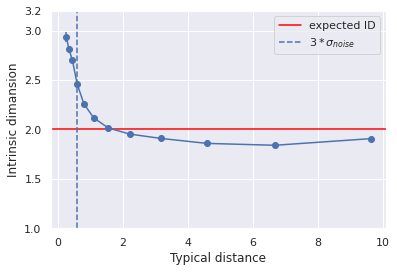

In [ ]:
#plot the intrinsic dimension as a function of the typical distance

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(scales, IDs, marker = 'o')
ax.errorbar(scales, IDs, 2*errs, marker = 'o')
ax.axhline(2, label = 'expected ID', color  = 'red')
ax.axvline(3*noise, label = '$3*\sigma_{noise}$', linestyle = '--')
ax.set_yticks([1, 1.5, 2, 2.5, 3, 3.2])
ax.set_ylabel('Intrinsic dimansion')
ax.set_xlabel('Typical distance')
ax.legend()



More examples on the use of DADApy to compute IDs are available at https://dadapy.readthedocs.io/en/latest/jupyter_example_3.html

### Comparing `return_scaling_2NN` and `return_scaling_Gride` on a spiral dataset

The Gride algorithm typically converges more quickly than 2NN+decimation to the true ID, this can be observed neatly in the following example where the two algorithms are compared on a spiral dataset.

In [ ]:
#1D spiral dataset with 3D noise
ndata = 5000
noise = 0.05
t = np.random.uniform(0, 10, ndata)
X = np.array([t*np.cos(t), t*np.sin(t), t]).T + noise*np.random.rand(ndata, 3)


In [ ]:
d = Data(X)
# compute ids with twoNN + decimation
ids_twoNN, ids_err_twoNN, rs_twoNN = d.return_id_scaling_2NN(N_min = 2)

# compute ids scaling gride
ids_gride, ids_err_gride, rs_gride = d.return_id_scaling_gride(range_max=d.N-1)

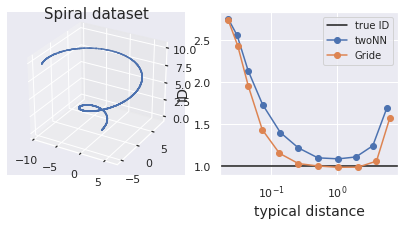

In [ ]:
fig = plt.figure(figsize = (7, 3))
gs = GridSpec(1,2)

ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s = 0.1)
ax.set_title('Spiral dataset', fontsize = 15)

ax = fig.add_subplot(gs[1])
ax.axhline(1, color = 'k', alpha = 1, label = 'true ID')
ax.plot(rs_twoNN, ids_twoNN,  marker = 'o', label = 'twoNN')
ax.plot(rs_gride, ids_gride,  marker = 'o', label = 'Gride')

ax.set_xscale('log')
ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('typical distance', fontsize = 14)
ax.legend(fontsize = 10)



## Intrinsic dimension of hidden deep neural network representations

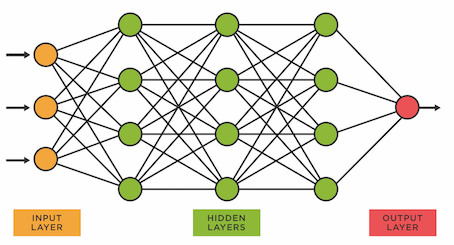

Convolutional neural networks used for image visione have up to hundreads of layers, along these layers data is transformed from the original pixel-representation to a representation which can discriminate between image cathegories.

Each layer is typically very "high-dimensional" with $D$ up to $D \sim 10^5 $ neurons (dimensions). 

But what is the intrinsic dimension $d$ of data in the hidden representation of a deep convolutional architecture?

#### Import the deep representations of a ResNet152 architecture trained on ImageNet

In [ ]:
# download a dataset containing the distances between 90000 ImageNet data points, 
# computed in the hidden representations of ResNet152 up the the 30th nearest neighbour

if not os.path.isdir("maxk_30"):
    from urllib.request import urlretrieve
    urlretrieve('https://ndownloader.figshare.com/files/22903688?private_link=6c875e9f4a31bfd79794', 'maxk_30.tar.gz')
    !tar -xzf maxk_30.tar.gz
    

In [ ]:
# the directory "maxk_30" now contains distances in the following layers

layers = os.listdir('maxk_30')
layers.sort()
layers

['layer_0.npz',
 'layer_1.npz',
 'layer_10.npz',
 'layer_142.npz',
 'layer_145.npz',
 'layer_148.npz',
 'layer_151.npz',
 'layer_152.npz',
 'layer_153.npz',
 'layer_34.npz',
 'layer_97.npz']

In [ ]:
# note that each file contains two separate Nx31 matrices of distances and indices

dists_npz = np.load('maxk_30/layer_0.npz')

print(dists_npz['dist'].shape)
print(dists_npz['index'].shape)

(90000, 31)
(90000, 31)


In [ ]:
# initialise a list of Data objects containing the distance matrices for the selected layers 
# note that Data objects can be initialised with sparse distance matrices!

checkpoints = [0, 1, 10, 34, 142, 151, 152, 153]

data_sets = []

for cp in checkpoints:
    dists_npz = np.load('maxk_30/layer_{}.npz'.format(cp))
    d = Data(distances=(dists_npz['dist'], dists_npz['index']))
    data_sets.append(d)
    


What kind of ID profile do we expect across the hidden layers of a deep neural network? 
Let's find out
 


In [ ]:
# let's check: compute the 2NN intrisic dimension across all layers 

_ = [d.compute_id_2NN()[0] for d in data_sets]

IDs = np.array([d.intrinsic_dim for d in data_sets])

/usr/local/lib/python3.7/dist-packages/dadapy/id_estimation.py:160: RuntimeWarning: divide by zero encountered in true_divide
  mus = np.log(distances[:, 2] / distances[:, 1])


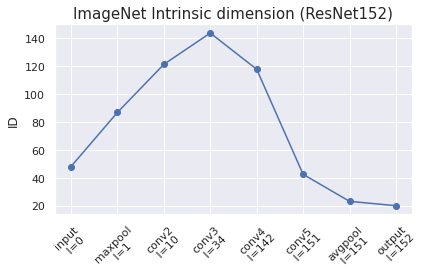

In [ ]:
# and now plot the intrisic dimesion profile of ResNet152 shown in figure A.4; also in this case 

layer_label = ['input\n l=0', 'maxpool\n l=1', 'conv2\n l=10', 'conv3\n l=34', 'conv4\n l=142', 'conv5\n l=151', 'avgpool\n l=151', 'output\n l=152']
cpt = np.array([0,1,2,3,5,8,9,10])
fig = plt.figure()

gs0 = GridSpec(1, 1)
ax1 = fig.add_subplot(gs0[0])
ax1.plot(np.arange(len(IDs)), IDs, label = 'ID', marker = 'o')
ax1.set_ylabel('ID')
ax1.set_xticks(np.arange(len(IDs)))
ax1.set_xticklabels(layer_label, rotation = 45)
ax1.set_title('ImageNet Intrinsic dimension (ResNet152)', fontsize = 15)
gs0.tight_layout(fig, rect = [0, 0, 1,1])


Contrary to what one might expect, the ID of hidden representations does not decrease monotonically from the input to the output layer. 

Instead, the ID shows a characteristic 'hunchback' profile, the ID first increases to a very high number giving rise to a truly high-dimensional "hyperspherical" representation, and then it diminishes quickly towards the output.

The reason behind this pehnomenon can be found in the fact that the network needs to first get rid of useless correlations in the data (such as luminosity gradients and colours) in order to construct meaningful semantic correlations later on.